# Section 0: Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


# Section 1:Training set overview

### 1.1 Read the training set

In [3]:
train = pd.read_csv('train.csv')
train.head(10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S  
8      2            347742  11.1333   NaN        S  
9      0            237736  30.0708   NaN        C

### 1.2 Take a look into the infomation of our training set

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.describe(include=['O'])

Name   Sex  Ticket        Cabin Embarked
count                                  891   891     891          204      889
unique                                 891     2     681          147        3
top     Cardeza, Mr. Thomas Drake Martinez  male  347082  C23 C25 C27        S
freq                                     1   577       7            4      644

### 1.3 Clean dataset
From the information above, we can drop three columns (PassengerId, Ticket, Cabin) first since:
- PassengerId: As same as row index
- Ticket:      No correlation with the target and the uniqueness
- Cabin:       Too many missing values

In [6]:
train.drop(['Ticket','Cabin','PassengerId'],axis=1,inplace=True)

# Section 2: Missing Values
First, I want to deal with the missing values.

As we can see, there are two features contain missing values: **Age** and **Embarked**

In [7]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

## 2.1 Strategies
There are three main strategies to deal with missing values:
1. Replace with the mean value
2. Replace with the most frequent value
3. Drop the whole row or the whole column

Since **Embarked** is a category feature, I replace the missing value with the **most frequent one**, which is **S**

In [8]:
train.groupby(['Embarked'])['Survived'].count().sort_values(ascending=False)

Embarked
S    644
C    168
Q     77
Name: Survived, dtype: int64

Since **Age** is a numertial feature, we can replace the missing value with the **mean**. But I want to do more. I take **Pclass** and **Sex** into consider, making me able to fill in a more accurate value.

In [10]:
train[['Age','Pclass',"Sex"]].groupby(['Pclass','Sex']).mean()

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

### Replace the missing values

In [12]:
train['Embarked'].replace(np.nan, 'S', inplace=True)

In [11]:
train.loc[(train['Pclass']==1) & (train['Sex']=='female') & (train['Age'].isnull()),'Age'] = 34.611765
train.loc[(train['Pclass']==2) & (train['Sex']=='female') & (train['Age'].isnull()),'Age'] = 28.722973
train.loc[(train['Pclass']==3) & (train['Sex']=='female') & (train['Age'].isnull()),'Age'] = 21.75
train.loc[(train['Pclass']==1) & (train['Sex']=='male') & (train['Age'].isnull()),'Age'] = 41.281386
train.loc[(train['Pclass']==2) & (train['Sex']=='male') & (train['Age'].isnull()),'Age'] = 30.740707
train.loc[(train['Pclass']==3) & (train['Sex']=='male') & (train['Age'].isnull()),'Age'] = 26.507589

Check again to make sure there are none missing

In [13]:
train.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

# Section 3: Data Oveview
Now we explore more deep into the data distribution of each feature. Let's see if there are any interesting patterns
## 3.1 Distribution of Target
First, explore the the distribution of the target, and make sure the targe is balanced. As we can see, although the number of **Not Survived** and the number of **Survived** are very close, we still have to deal it carefully when we split data into training set and validation set later. 

In [14]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [15]:
sns.countplot('Survived',data=train, palette ='Set2')

## 3.2 Gender
The surviving rate of male and female are very different. From the dataframe below, we can see that the surviving chance of female (74.2%) is way better than male (18.89%). I think it is easy to understand this pattern since in the movie Titanic, the female has higher priority than male to get on the life boat.

In [16]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [17]:
train[['Survived','Sex']].groupby(['Sex']).mean()

Survived
Sex             
female  0.742038
male    0.188908

## 3.3 Pclass
The surviving rate of different Pclass are also different. From the dataframe below, we can see that the with higher pclass, the higher surviving rate. I think it might because the richer people has more stuffs to make them survived.

In [18]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [19]:
train[['Survived','Pclass']].groupby(['Pclass']).mean()

Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363

## 3.4 Family Size
I want to bring these two features: **SibSp** and **Parch** in the same part together. As we can see, there are no obvious correlation of these two features with the target. Thus, I will combine them into the new feature **Family Size** in the next section.
### 3.4.1 Number of Siblings

In [20]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [21]:
train[['Survived','SibSp']].groupby(['SibSp']).mean().sort_values(by=['Survived'],ascending=False)

Survived
SibSp          
1      0.535885
2      0.464286
0      0.345395
3      0.250000
4      0.166667
5      0.000000
8      0.000000

### 3.4.2 Number of Parents

In [22]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [23]:
train[['Survived','Parch']].groupby(['Parch']).mean().sort_values(by=['Survived'],ascending=False)

Survived
Parch          
3      0.600000
1      0.550847
2      0.500000
0      0.343658
5      0.200000
4      0.000000
6      0.000000

## 3.5 Embarked
In this feature, there is no obvious different between each category, but **C** has a little higer survival rate than the other. 

In [24]:
train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [25]:
train[['Survived','Embarked']].groupby(['Embarked']).mean().sort_values(by=['Survived'],ascending=False)

Survived
Embarked          
C         0.553571
Q         0.389610
S         0.339009

## 3.6 Age
The most of the passenger are 20~40 years old. From the kde plot of survived and not survived v.s. age below, I will categorize passenger into **5** groups in the next section according to their surviving rate.
1. Age <= 17
2. 17 < Age <= 31
3. 31 < Age <= 40
4. 40 < Age <= 59
5. Age > 59

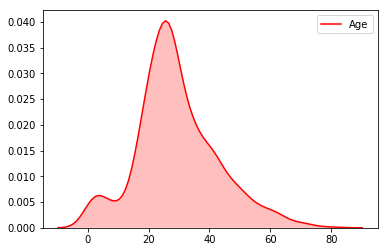

In [26]:
sns.kdeplot(train['Age'],shade=True,color='r')

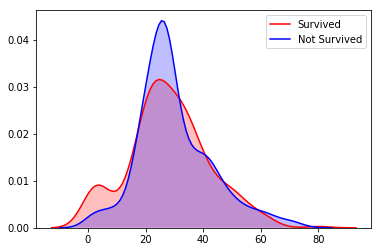

In [27]:
fig, ax = plt.subplots(1,1)
sns.kdeplot(train[train['Survived']==1]['Age'],shade=True,color='r')
sns.kdeplot(train[train['Survived']==0]['Age'],shade=True,color='b')
plt.legend(['Survived','Not Survived'])
plt.show()

## 3.7 Fare
The most of the fare are 0~60. From the kde plot of survived and not survived v.s. fare below, I will categorize passenger into **2** groups in the next section according to their surviving rate.
1. Fare <= 30
2. Fare > 30

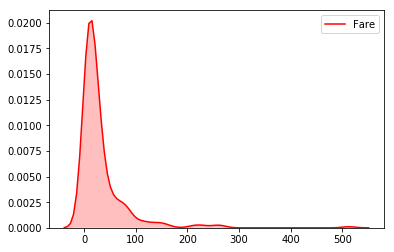

In [28]:
sns.kdeplot(train['Fare'],shade=True,color='r')

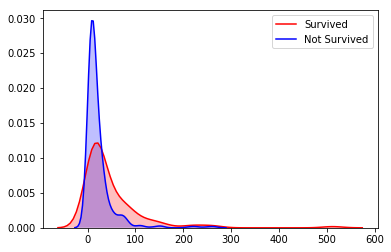

In [29]:
#%matplotlib notebook
fig, ax = plt.subplots(1,1)
sns.kdeplot(train[train['Survived']==1]['Fare'],shade=True,color='r')
sns.kdeplot(train[train['Survived']==0]['Fare'],shade=True,color='b')
plt.legend(['Survived','Not Survived'])
plt.show()

# Section 4: Feature Engineering
In this section, I will perform feature engineering to build new features according to the pattern we found in the last section.
## 4.1 New Feature
1. **Title**: Extract the title part from the names
2. **Family Size**: Combine **SibSp** and **Parch**
3. **Alone**: The passenger is alone or not according to **SibSp** and **Parch**
4. **Age interval**: Categorize age into 5 groups
5. **Fare interval**: Categorize fare into 2 groups

In [30]:
train['Title'] = train['Name'].str.split(",",expand=True)[1].str.split(".",expand=True)[0]
train['Family Size'] = train['Parch']+train["SibSp"]+1
train['Alone'] = 1
train.loc[(train['SibSp']>0) | (train['Parch']>0),'Alone'] = 0
train['Age_interval'] = 0
train.loc[(train['Age']>17) & (train['Age']<=31),'Age_interval'] = 1
train.loc[(train['Age']>31) & (train['Age']<=40),'Age_interval'] = 2
train.loc[(train['Age']>40) & (train['Age']<=59),'Age_interval'] = 3
train.loc[train['Age']>59,'Age_interval'] = 4
train['Fare_interval'] = 0
train.loc[train['Fare']>30,'Fare_interval'] = 1
train

Survived  Pclass                                               Name  \
0           0       3                            Braund, Mr. Owen Harris   
1           1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2           1       3                             Heikkinen, Miss. Laina   
3           1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4           0       3                           Allen, Mr. William Henry   
..        ...     ...                                                ...   
886         0       2                              Montvila, Rev. Juozas   
887         1       1                       Graham, Miss. Margaret Edith   
888         0       3           Johnston, Miss. Catherine Helen "Carrie"   
889         1       1                              Behr, Mr. Karl Howell   
890         0       3                                Dooley, Mr. Patrick   

        Sex    Age  SibSp  Parch     Fare Embarked  Title  Family Size  Alone  \
0      male  22.00      1      0   7.2500        S     Mr            2      0   
1    female  38.00      1      0  71.2833        C    Mrs            2      0   
2    female  26.00      0      0   7.9250        S   Miss            1      1   
3    female  35.00      1      0  53.1000        S    Mrs            2      0   
4      male  35.00      0      0   8.0500        S     Mr            1      1   
..      ...    ...    ...    ...      ...      ...    ...          ...    ...   
886    male  27.00      0      0  13.0000        S    Rev            1      1   
887  female  19.00      0      0  30.0000        S   Miss            1      1   
888  female  21.75      1      2  23.4500        S   Miss            4      0   
889    male  26.00      0      0  30.0000        C     Mr            1      1   
890    male  32.00      0      0   7.7500        Q     Mr            1      1   

     Age_interval  Fare_interval  
0               1              0  
1               2              1  
2               1              0  
3               2              1  
4               2              0  
..            ...            ...  
886             1              0  
887             1              0  
888             1              0  
889             1              0  
890             2              0  

[891 rows x 14 columns]

Now we can drop **Name**, **SibSp** and **Parch** safely since we've already made a new feature for them. 

In [31]:
train.drop(['Name','SibSp','Parch'],axis=1,inplace=True)
train

Survived  Pclass     Sex    Age     Fare Embarked  Title  Family Size  \
0           0       3    male  22.00   7.2500        S     Mr            2   
1           1       1  female  38.00  71.2833        C    Mrs            2   
2           1       3  female  26.00   7.9250        S   Miss            1   
3           1       1  female  35.00  53.1000        S    Mrs            2   
4           0       3    male  35.00   8.0500        S     Mr            1   
..        ...     ...     ...    ...      ...      ...    ...          ...   
886         0       2    male  27.00  13.0000        S    Rev            1   
887         1       1  female  19.00  30.0000        S   Miss            1   
888         0       3  female  21.75  23.4500        S   Miss            4   
889         1       1    male  26.00  30.0000        C     Mr            1   
890         0       3    male  32.00   7.7500        Q     Mr            1   

     Alone  Age_interval  Fare_interval  
0        0             1              0  
1        0             2              1  
2        1             1              0  
3        0             2              1  
4        1             2              0  
..     ...           ...            ...  
886      1             1              0  
887      1             1              0  
888      0             1              0  
889      1             1              0  
890      1             2              0  

[891 rows x 11 columns]

## 4.2 Look at new features
Let's see how our new feature perform.

### 4.2.1 Age intervals v.s. Survived

In [32]:
train[['Survived','Age_interval']].groupby(['Age_interval']).mean().sort_values(by=['Survived'],ascending=False)

Survived
Age_interval          
0             0.539823
2             0.482759
3             0.365517
1             0.326840
4             0.269231

### 4.2.2 Fare intervals v.s. Survived

In [33]:
train[['Survived','Fare_interval']].groupby(['Fare_interval']).mean().sort_values(by=['Survived'],ascending=False)

Survived
Fare_interval          
1              0.581197
0              0.313546

### 4.2.3 Family size v.s. Survived
In this feature, it's still a little mess. Thus, I group them into **3** groups
1. 1: Alone
2. 2,3,4: This group has higer surviving rate
3. \>4: This group has lower surviving rate

In [34]:
train[['Survived','Family Size']].groupby(['Family Size']).mean().sort_values(by=['Survived'],ascending=False)

Survived
Family Size          
4            0.724138
3            0.578431
2            0.552795
7            0.333333
1            0.303538
5            0.200000
6            0.136364
8            0.000000
11           0.000000

In [35]:
train['Family Size']=train['Family Size'].replace([2,3,4],2)
train['Family Size']=train['Family Size'].replace([5,6,7,8,11],3)
train[['Survived','Family Size']].groupby(['Family Size']).mean().sort_values(by=['Survived'],ascending=False)

Survived
Family Size          
2            0.578767
1            0.303538
3            0.161290

### 4.2.4 Alone
Being alone has lower surviving rate. Since this feature is similar to the **family size**, it will be drop in the modeling section.

In [36]:
train[['Survived','Alone']].groupby(['Alone']).mean().sort_values(by=['Survived'],ascending=False)

Survived
Alone          
0      0.505650
1      0.303538

### 4.2.5 Title
We extract title from names, here is a little mess. I group them into **Mr, Miss, Mrs, Master and others** according to their frequency and surviving rate.

In [37]:
train['Title'].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Col               2
 Mlle              2
 Major             2
 Don               1
 Ms                1
 Lady              1
 Jonkheer          1
 Mme               1
 the Countess      1
 Capt              1
 Sir               1
Name: Title, dtype: int64

In [38]:
train[['Survived','Title']].groupby(['Title']).mean().sort_values(by=['Survived'],ascending=False)

Survived
Title                  
 the Countess  1.000000
 Mlle          1.000000
 Sir           1.000000
 Ms            1.000000
 Lady          1.000000
 Mme           1.000000
 Mrs           0.792000
 Miss          0.697802
 Master        0.575000
 Col           0.500000
 Major         0.500000
 Dr            0.428571
 Mr            0.156673
 Jonkheer      0.000000
 Rev           0.000000
 Don           0.000000
 Capt          0.000000

In [68]:
# Grouping
train['Title']=train['Title'].replace([' the Countess',' Sir',' Capt',' Jonkheer',' Don',' Col',' Major',' Rev',' Dr'],'others')
train['Title']=train['Title'].replace([' Ms',' Mlle',' Lady'],' Miss')
train['Title']=train['Title'].replace([' Mme'],' Mrs')

In [69]:
# Mr has low surviving rate, as same as feature "male"
train[['Survived','Title']].groupby(['Title']).mean().sort_values(by=['Survived'],ascending=False)

Survived
Title          
0      0.793651
1      0.704301
2      0.575000
3      0.318182
4      0.156673

## 4.3 Final explortion
I combine all we've seen into plot here together.

### 4.3.1 All of the features v.s. survived

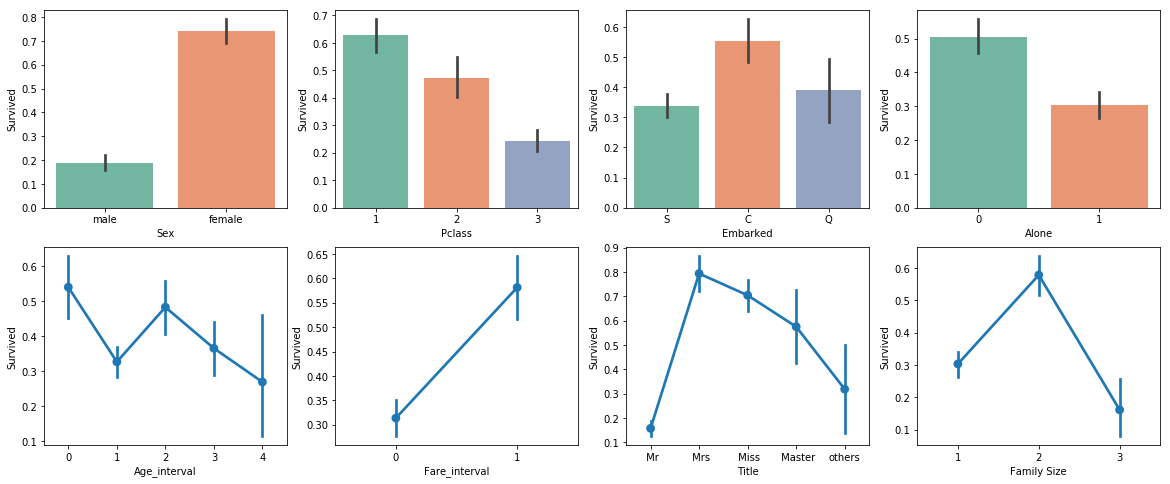

In [41]:
fig, ax = plt.subplots(2, 4,figsize=(20,8))

sns.barplot(x = 'Sex', y = 'Survived', data=train, ax = ax[0,0], palette="Set2")
sns.barplot(x = 'Pclass', y = 'Survived', data=train, ax = ax[0,1], palette="Set2")
sns.barplot(x = 'Embarked', y = 'Survived', data=train, ax = ax[0,2], palette="Set2")
sns.barplot(x = 'Alone', y = 'Survived', data=train, ax = ax[0,3], palette="Set2")

sns.pointplot(x = 'Age_interval', y = 'Survived',  data=train, ax = ax[1,0])
sns.pointplot(x = 'Fare_interval', y = 'Survived',  data=train, ax = ax[1,1])
sns.pointplot(x = 'Title', y = 'Survived',  data=train, ax = ax[1,2])
sns.pointplot(x = 'Family Size', y = 'Survived', data=train, ax = ax[1,3])

### 4.3.2 Feature + feature v.s. survived
There are two features is very revelent to the target: **Sex** and **Pclass**. Let's see if there is any interesting pattern of them when with other features.

#### Pclass

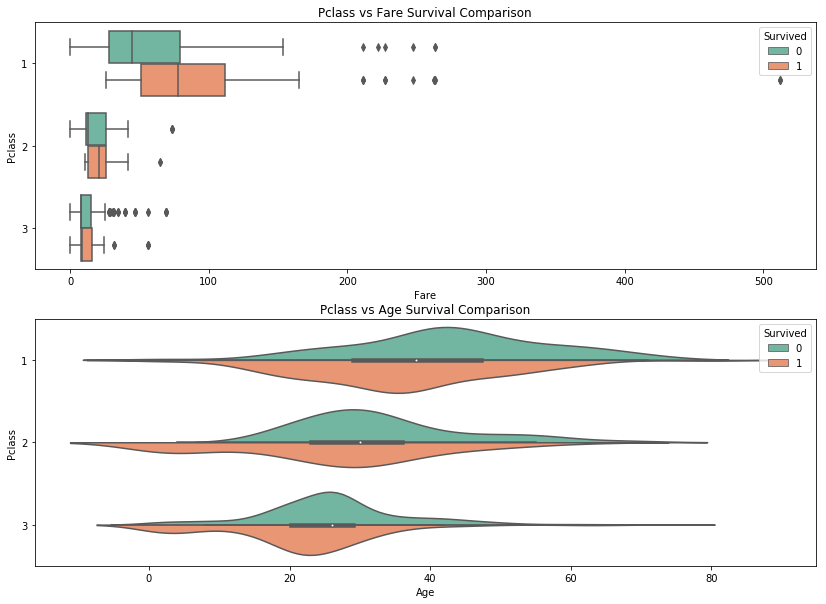

In [42]:
train['Pclass']=train['Pclass'].astype("category")
fig, ax = plt.subplots(2,1,figsize=(14,10))

sns.boxplot(y = 'Pclass', x = 'Fare', hue = 'Survived', data = train, ax = ax[0], palette="Set2")
ax[0].set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(y = 'Pclass', x = 'Age', hue = 'Survived', data = train, split = True, ax = ax[1], palette="Set2")
ax[1].set_title('Pclass vs Age Survival Comparison')
train['Pclass']=train['Pclass'].astype(int)

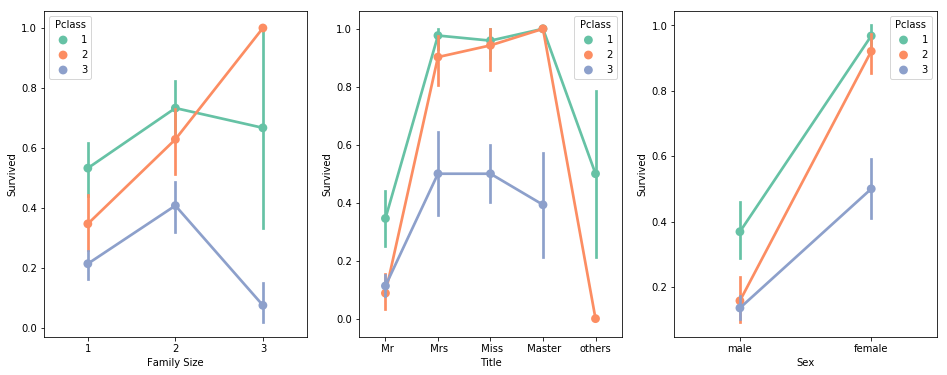

In [43]:
fig, ax = plt.subplots(1, 3,figsize=(16,6))

sns.pointplot(x="Family Size", y="Survived", hue="Pclass", data=train,ax = ax[0], palette="Set2")
sns.pointplot(x="Title", y="Survived", hue="Pclass", data=train,ax = ax[1], palette="Set2")
sns.pointplot(x="Sex", y="Survived", hue="Pclass", data=train,ax = ax[2], palette="Set2")

#### Sex

Text(0.5,1,'Sex vs Age Survival Comparison')

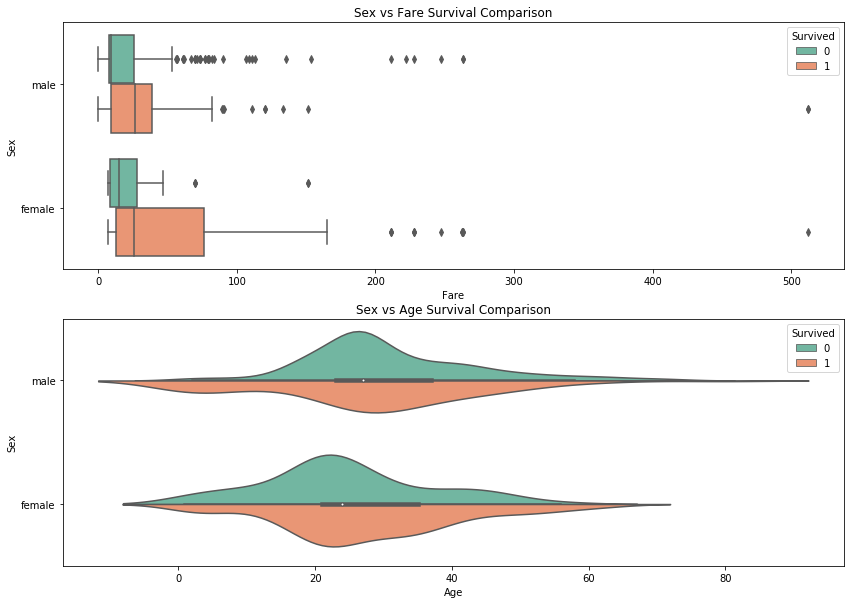

In [44]:
fig, ax = plt.subplots(2,1,figsize=(14,10))

sns.boxplot(y = 'Sex', x = 'Fare', hue = 'Survived', data = train, ax = ax[0], palette="Set2")
ax[0].set_title('Sex vs Fare Survival Comparison')

sns.violinplot(y = 'Sex', x = 'Age', hue = 'Survived', data = train, split = True, ax = ax[1], palette="Set2")
ax[1].set_title('Sex vs Age Survival Comparison')

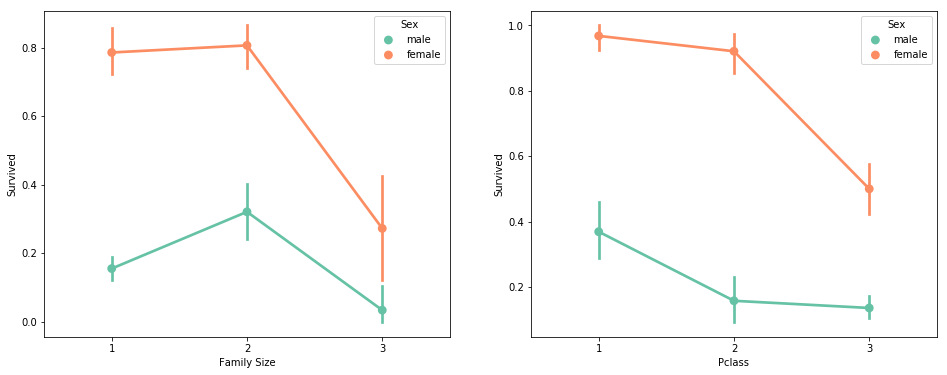

In [45]:
fig, ax = plt.subplots(1, 2,figsize=(16,6))

sns.pointplot(x="Family Size", y="Survived", hue="Sex", data=train,ax = ax[0], palette="Set2")
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=train,ax = ax[1], palette="Set2")

## 4.4 Encoding
In the last part of feature engineering, we have to make our data readable for our model. Thus, we encode category features into numbers.

In [46]:
train['Sex'] = train['Sex'].map({'female':0,'male':1})
train['Embarked'] = train['Embarked'].map({'S':0,'Q':1,'C':2})
train['Title'] = train['Title'].map({' Mrs':0,' Miss':1,' Master':2, 'others':3, ' Mr':4})

## 4.5 Final check

In [47]:
train

Survived  Pclass  Sex    Age     Fare  Embarked  Title  Family Size  \
0           0       3    1  22.00   7.2500         0      4            2   
1           1       1    0  38.00  71.2833         2      0            2   
2           1       3    0  26.00   7.9250         0      1            1   
3           1       1    0  35.00  53.1000         0      0            2   
4           0       3    1  35.00   8.0500         0      4            1   
..        ...     ...  ...    ...      ...       ...    ...          ...   
886         0       2    1  27.00  13.0000         0      3            1   
887         1       1    0  19.00  30.0000         0      1            1   
888         0       3    0  21.75  23.4500         0      1            2   
889         1       1    1  26.00  30.0000         2      4            1   
890         0       3    1  32.00   7.7500         1      4            1   

     Alone  Age_interval  Fare_interval  
0        0             1              0  
1        0             2              1  
2        1             1              0  
3        0             2              1  
4        1             2              0  
..     ...           ...            ...  
886      1             1              0  
887      1             1              0  
888      0             1              0  
889      1             1              0  
890      1             2              0  

[891 rows x 11 columns]

# Section 5: Modeling
In this section, I will try different machine learning models to find the best one.

## 5.0 Set up
Prepare the libraries and our input data into desired format

In [48]:
from sklearn import preprocessing
from sklearn import model_selection

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, log_loss, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [49]:
# Drop the redundant features
X = train.drop(['Survived','Age','Fare','Alone'],axis=1)
Y = train['Survived']

In [50]:
X

Pclass  Sex  Embarked  Title  Family Size  Age_interval  Fare_interval
0         3    1         0      4            2             1              0
1         1    0         2      0            2             2              1
2         3    0         0      1            1             1              0
3         1    0         0      0            2             2              1
4         3    1         0      4            1             2              0
..      ...  ...       ...    ...          ...           ...            ...
886       2    1         0      3            1             1              0
887       1    0         0      1            1             1              0
888       3    0         0      1            2             1              0
889       1    1         2      4            1             1              0
890       3    1         1      4            1             2              0

[891 rows x 7 columns]

## 5.1 Cross Validation
Here, I perform a **10-fold stratified cross validation** to explore the performance of different machine learing classifiers. I choose classifiers from different methods those are able to deal with a **non-linear** data such as KNN, SVM, Decision Tree. I also select the classifiers which are very popular in recent competitions. They use ensemble methods to get better performance, such as Random Forest, AdaBoost, XGBoost. 

In [81]:
# All the ML classifiers
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    LogisticRegression(),
    SVC(),
    XGBClassifier()]

# Store the performacne(accracy)
acc_dict={}

# Prepare the stratified shuffled training(75%) and validation(25%) data
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=0)

# Classify
for clf in classifiers:
    name = clf.__class__.__name__
    print(name)
    cv_results = model_selection.cross_validate(clf, X, Y, cv = sss)
    acc_dict[name] = cv_results['test_score'].mean()

# Put results into dataframe for further explortion
log = pd.DataFrame.from_dict(acc_dict, orient='index', columns=['acc'])
log = log.sort_values(['acc'],ascending=False)

KNeighborsClassifier
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
LogisticRegression
SVC
XGBClassifier


Now, we can see that both **AdaBoost** and **SVM** outperformance than other classifiers. In this time, although all the hyperparameters of the classifiers are set to default, the AdaBoost classifier, an ensemble method, can already outperform SVM, the strongest classifier which can map data points to high dimensions in order to find a proper decision boundary.

In [82]:
log

acc
AdaBoostClassifier      0.834081
SVC                     0.832287
LogisticRegression      0.823767
KNeighborsClassifier    0.821525
XGBClassifier           0.814350
RandomForestClassifier  0.801794
DecisionTreeClassifier  0.799103

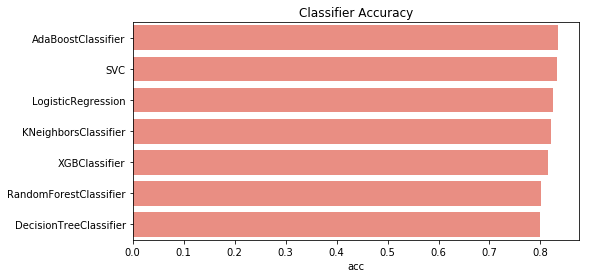

In [83]:
fig = plt.figure(figsize=(8,4))
plt.title('Classifier Accuracy')
sns.barplot(x='acc', y=log.index, data=log, color = 'salmon')
plt.show()

## 5.2 Fine-tuning
When we use the sklearn classifiers, the hyperparameters will be set to default if we don't give it values. However, a pair of appropriate hyperparameter will extremely influence the performance of the model. Here I use grid search to find the best pair of hyperparameters for our models.

In [85]:
log['acc_after']=0
grid_n_estimator = [10, 50, 100, 300, 500, 700]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

grid_param = [{
            #KNeighborsClassifier
            'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            },
            
            {
            # DecisionTreeClassifier
            'criterion': grid_criterion,  #scoring methodology; two supported formulas for calculating information gain - default is gini
            'max_depth': grid_max_depth, #max depth tree can grow; default is none
            'random_state': grid_seed
            },
    
            {
            #RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True],
            'random_state': grid_seed
            },
    
            {
            #AdaBoostClassifier
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            'random_state': grid_seed
            },
    
            {
            #LogisticRegression
            'fit_intercept': grid_bool, #default: True
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
            },
    
            {
            #SVC
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
            },
    
            {
            #XGBClassifier
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
            }  
        ]

In [86]:
for idx,clf in enumerate(classifiers):
    print(clf.__class__.__name__)
    tune_model = model_selection.GridSearchCV(clf, param_grid=grid_param[idx], scoring = 'roc_auc', cv = sss)
    tune_model.fit(train.drop(['Survived','Age','Fare','Alone'],axis=1), train['Survived'])
    print('Best parameters: ',tune_model.best_params_)
    print('New Acc: ',tune_model.cv_results_['mean_test_score'][tune_model.best_index_])
    log.loc[clf.__class__.__name__,'acc_after']=tune_model.cv_results_['mean_test_score'][tune_model.best_index_]
    print('-'*10)

KNeighborsClassifier
Best parameters:  {'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'uniform'}
New Acc:  0.853619928704804
----------
DecisionTreeClassifier
Best parameters:  {'criterion': 'entropy', 'max_depth': 4, 'random_state': 0}
New Acc:  0.8633848243082668
----------
RandomForestClassifier
Best parameters:  {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 100, 'oob_score': True, 'random_state': 0}
New Acc:  0.8690587336615176
----------
AdaBoostClassifier
Best parameters:  {'learning_rate': 0.25, 'n_estimators': 300, 'random_state': 0}
New Acc:  0.8746477677813613
----------
LogisticRegression
Best parameters:  {'fit_intercept': True, 'random_state': 0, 'solver': 'newton-cg'}
New Acc:  0.8658037684603631
----------
SVC
Best parameters:  {'C': 3, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'probability': True, 'random_state': 0}
New Acc:  0.8589076557460533
----------
XGBClassifier
Best parameters:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 700, 

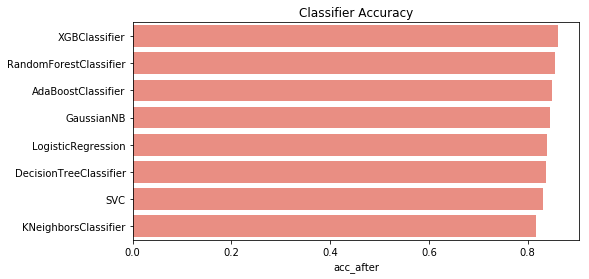

In [60]:
fig = plt.figure(figsize=(8,4))
log = log.sort_values(['acc_after'],ascending=False)
plt.title('Classifier Accuracy')
sns.barplot(x='acc_after', y=log.index, data=log, color = 'salmon')
plt.show()

## 5.3 Desicion
After fine-tuning, the **XGBClassifier** becomes the best classifier(87.93%), and then **AdaBoost**(87.46%). As we can see from the results, the method that uses trees can better deal with non-linear data, such as decision tree. Moreover, under the base of tree, the classifiers that use the ensemble methods easily beat other classifiers since they bulid lots of trees, those trees are being built based on defect of last tree, to vote for the final prediction. Thus, I use **XGBClassifier** as the final decision to predict the testing set.

# Section 6: Predict

## 6.0 Set up
First, we load the testing set. Then we perform the feature engineering as same as we've done to the training set in section 4.

In [61]:
test = pd.read_csv('test.csv')

Note here, the feature "Fare" in testing set has a missing value, which did not happen in the training. I will replace it with the mean of the fare in the training data.

In [62]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [63]:
# Perform feature engineering as same as Section 4
test.drop(['Ticket','Cabin'],axis=1,inplace=True)
test.loc[(test['Pclass']==1) & (test['Sex']=='female') & (test['Age'].isnull()),'Age'] = 34.611765
test.loc[(test['Pclass']==2) & (test['Sex']=='female') & (test['Age'].isnull()),'Age'] = 28.722973
test.loc[(test['Pclass']==3) & (test['Sex']=='female') & (test['Age'].isnull()),'Age'] = 21.75
test.loc[(test['Pclass']==1) & (test['Sex']=='male') & (test['Age'].isnull()),'Age'] = 41.281386
test.loc[(test['Pclass']==2) & (test['Sex']=='male') & (test['Age'].isnull()),'Age'] = 30.740707
test.loc[(test['Pclass']==3) & (test['Sex']=='male') & (test['Age'].isnull()),'Age'] = 26.507589
test['Embarked'].replace(np.nan, 'S', inplace=True)
test['Fare'].replace(np.nan,train['Fare'].mean(),inplace=True)
test['Title'] = test['Name'].str.split(",",expand=True)[1].str.split(".",expand=True)[0]
test['Family Size'] = test['Parch']+test["SibSp"]+1
test['Alone'] = 1
test.loc[(test['SibSp']>0) | (test['Parch']>0),'Alone'] = 0
test['Age_interval'] = 0
test.loc[(test['Age']>17) & (test['Age']<=31),'Age_interval'] = 1
test.loc[(test['Age']>31) & (test['Age']<=40),'Age_interval'] = 2
test.loc[(test['Age']>40) & (test['Age']<=59),'Age_interval'] = 3
test.loc[test['Age']>59,'Age_interval'] = 4
test['Fare_interval'] = 0
test.loc[test['Fare']>30,'Fare_interval'] = 1

test.drop(['Name','SibSp','Parch'],axis=1,inplace=True)
test['Family Size']=test['Family Size'].replace([2,3,4],2)
test['Family Size']=test['Family Size'].replace([5,6,7,8,11],3)
test['Title']=test['Title'].replace([' the Countess',' Sir',' Capt',' Jonkheer',' Don',' Col',' Major',' Rev',' Dr',' Dona'],'others')
test['Title']=test['Title'].replace([' Ms',' Mlle',' Lady'],' Miss')
test['Title']=test['Title'].replace([' Mme'],' Mrs')

test['Sex'] = test['Sex'].map({'female':0,'male':1})
test['Embarked'] = test['Embarked'].map({'S':0,'Q':1,'C':2})
test['Title'] = test['Title'].map({' Mrs':0,' Miss':1,' Master':2, 'others':3, ' Mr':4})

In [64]:
# Drop redundant features
X_test = test.drop(["PassengerId",'Age','Fare','Alone'],axis=1).values

In [65]:
# Final check
test.drop(["PassengerId",'Age','Fare','Alone'],axis=1)

Pclass  Sex  Embarked  Title  Family Size  Age_interval  Fare_interval
0         3    1         1      4            1             2              0
1         3    0         0      0            2             3              0
2         2    1         1      4            1             4              0
3         3    1         0      4            1             1              0
4         3    0         0      0            2             1              0
..      ...  ...       ...    ...          ...           ...            ...
413       3    1         0      4            1             1              0
414       1    0         2      3            1             2              1
415       3    1         0      4            1             2              0
416       3    1         0      4            1             1              0
417       3    1         2      2            2             1              0

[418 rows x 7 columns]

In [66]:
# Use the whole training set for training
X = train.drop(['Survived','Age','Fare','Alone'],axis=1).values
Y = train['Survived'].astype(int).values.reshape(-1,)

## 6.1 Predict and submit

In [87]:
# Use model we choosed in the end of Section 5
model = XGBClassifier(learning_rate=0.01, max_depth=2, n_estimators=700, seed=0)
model.fit(X, Y)

# Predict
Y_pred = model.predict(X_test)

# Write result to csv for submission
test['Survived'] = Y_pred
test[['PassengerId','Survived']].to_csv('submission.csv',index=False)

## The final score of my submission on Kaggle is 0.77511